# AMOS 2024 - BARPA - Australian annual mean temperature

In this notebook we explore the annual mean warming of the dynamically downscaled BARPA-R simulations. The goal is to load the historical and ssp370 scenario for one downscaled CMIP6 model and plot the annual mean temperature over time.

First we load the required python modules and start a dask client to speed up our computation.

In [1]:
import tempfile
import dask.distributed
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
client = dask.distributed.Client(local_directory=tempfile.mkdtemp())
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38149,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:33183,Total threads: 2
Dashboard: /proxy/43807/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:36151,


Now that we have a client (click on "Launch dashboard in JupyterLab" to see the dask dashboard) running lets open the historical and ssp370 files for ACCESS-CM2 downscaled simulation. For this we use xarray's open_mfdataset function with parallel set to true. 

You can see the progress of opening the files in the dask dashboard.

## Introduction

In [3]:
realisation = "r4i1p1f1"
ta_hist_files = f"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/historical/{realisation}/BARPA-R/v1-r1/mon/tas/v20231001/*.nc"
ta_hist = xr.open_mfdataset(ta_hist_files, parallel=True)

ta_ssp_files = f"/g/data/py18/admin/testing/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/{realisation}/BARPA-R/v1-r1/mon/tas/v20231001/*.nc"
ta_ssp = xr.open_mfdataset(ta_ssp_files, parallel=True)

We can also inspect the dataset we have just opened. If you click on "Attributes" you can get much more information about the content of the files you have just opened, such as information about the driving model, the native resolution of BARPA-R, etc.

In [4]:
ta_hist

<xarray.Dataset>
Dimensions:    (time: 660, lat: 436, lon: 777, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon        (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
    height     float64 1.5
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float64 dask.array<chunksize=(3, 221, 395), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/58)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1M.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    title:                     Bureau of Meteorology Atmospheric Regional Pro...
    ...                        ...
    driving_experiment:        CSIRO-ARCCSS ACCESS-CM2; historical; r4i1p1f1
    driving_source_id:         ACCESS-CM2
    date_modified:             2023-12-19T11:46:12Z
    date_metadata_modified:    2023-12-19T11:46:12Z
    history:                   Tue Dec 19 11:46:12 2023: ncrename -v tasmean,...
    NCO:                       netCDF Operators version 5.0.5 (Homepage = htt...

Instead of two individual datasets for the historical and future scenario it is much easier to work with one combined dataset. For this we use xarray's concat function to concatenate the two datasets along the time dimension.

In [5]:
ta = xr.concat(
    [ta_hist, ta_ssp],
    dim="time"
)

Also we are only interested in the near-surface temperature (tas) of the dataset. Therefore we extract "tas" from the dataset and turn it into a dataarray. The advantage of this is that datasets cannot be plotted directly but dataarrays can.

In [6]:
ta = ta["tas"]

Next we perform some calculations. To plot the annual mean temperature over time we need to calculate the area mean of the domain as well as the yearly mean and then pass this to the plot routine.

In [7]:
ta_mn = ta.mean(["lat", "lon"])

In [8]:
ta_mn = ta_mn.resample({"time":"1Y"}).mean()

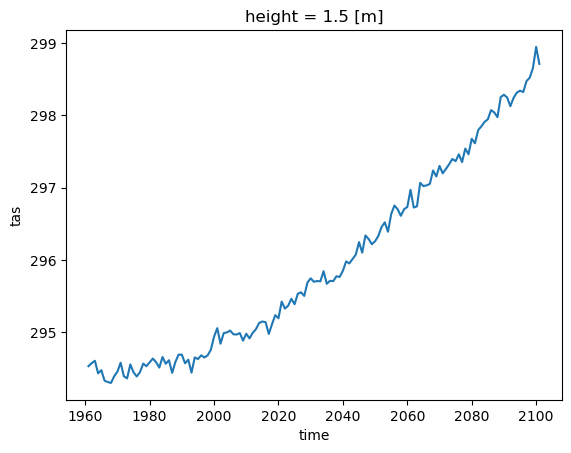

In [9]:
ta_mn.plot()

## Excercise 1 (optional)
BARPA-R has downscaled 7 CMIP6 models, which are listed below. In the introduction we only plotted the annual mean of one model, ACCESS-CM2. Extending on the above code, can you plot the annual and area mean for all 7 models over time?

Hint: A loop over the model_list below and modifying the path to the BARPA-R files above will help you to load all the monthly files you need.

Hint 2: Different models may have different realisations (e.g., r1i1p1f1). Using * can help you select all realisations.

In [10]:
model_list = [
    "ACCESS-CM2",
    "ACCESS-ESM1-5",
    "CESM2",
    "CMCC-ESM2",
    "EC-Earth3",
    "MPI-ESM1-2-HR",
    "NorESM2-MM",
]

In [11]:
# !!! REMOVE FOR EXERCISE !!!
realisation = "*"
ta_model = {}
for model in model_list:
    ta_hist_files = f"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/{model}/historical/{realisation}/BARPA-R/v1-r1/mon/tas/v20231001/*.nc"
    ta_hist = xr.open_mfdataset(ta_hist_files, parallel=True)
    ta_ssp_files = f"/g/data/py18/admin/testing/BARPA/output/CMIP6/DD/AUS-15/BOM/{model}/ssp370/{realisation}/BARPA-R/v1-r1/mon/tas/v20231001/*.nc"
    ta_ssp = xr.open_mfdataset(ta_ssp_files, parallel=True)
    
    ta_model[model] = xr.concat(
        [ta_hist, ta_ssp],
        dim="time"
    )["tas"]

In [12]:
# !!! REMOVE FOR EXERCISE !!!
ta_model_mn = {}
for model in ta_model:
    ta_model_mn[model] = ta_model[model].mean(["lat", "lon"]).resample({"time":"1Y"}).mean().compute()

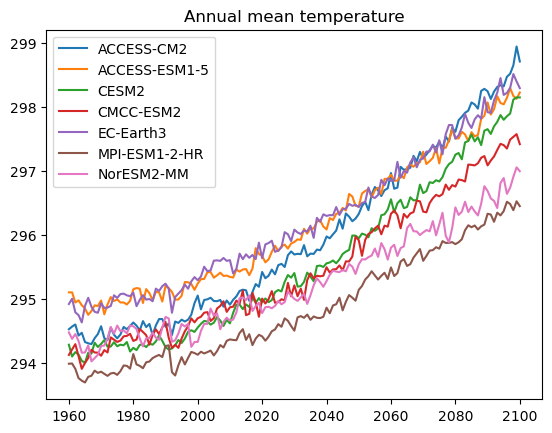

In [13]:
# !!! REMOVE FOR EXERCISE !!!
for model in ta_model_mn:
    plt.plot(ta_model_mn[model]["time"].dt.year, ta_model_mn[model], label=model)
    plt.legend()
    plt.title("Annual mean temperature")

## Excercise 2 (optional)
Now we extend our analysis by looking at an additional variable, precipitation.
Can you plot the annual maximum hourly precipitation rate over time? 

Hint: The variable to use for this is under the frequency directory "day" (instead of "mon") and is called "prhmax".

Hint 2: Opening and performing computations on daily files will take longer and more notebook resources might be required; you are opening 34GB of data.

Hint 3: Add chunks={"time":512, "lat":None, "lon":None} as argument to open_mfdataset. This will help load your data faster. It will still take several minutes to process the data for all 7 models.

In [14]:
# !!! REMOVE FOR EXERCISE !!!
realisation = "*"
prhmax_model = {}
for model in model_list:
    prhmax_hist_files = f"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/{model}/historical/{realisation}/BARPA-R/v1-r1/day/prhmax/v20231001/*.nc"
    prhmax_hist = xr.open_mfdataset(prhmax_hist_files, parallel=True, chunks={"time":512, "lat":None, "lon":None})
    prhmax_ssp_files = f"/g/data/py18/admin/testing/BARPA/output/CMIP6/DD/AUS-15/BOM/{model}/ssp370/{realisation}/BARPA-R/v1-r1/day/prhmax/v20231001/*.nc"
    prhmax_ssp = xr.open_mfdataset(prhmax_ssp_files, parallel=True, chunks={"time":512, "lat":None, "lon":None})
    
    prhmax_model[model] = xr.concat(
        [prhmax_hist, prhmax_ssp],
        dim="time"
    )["prhmax"]

In [15]:
# !!! REMOVE FOR EXERCISE !!!
prhmax_model_mn = {}
for model in model_list:
    prhmax_model_mn[model] = prhmax_model[model].max(["lat", "lon"]).resample({"time":"1Y"}).max().compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 11.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 11.85 MiB.
This may cause some slowd

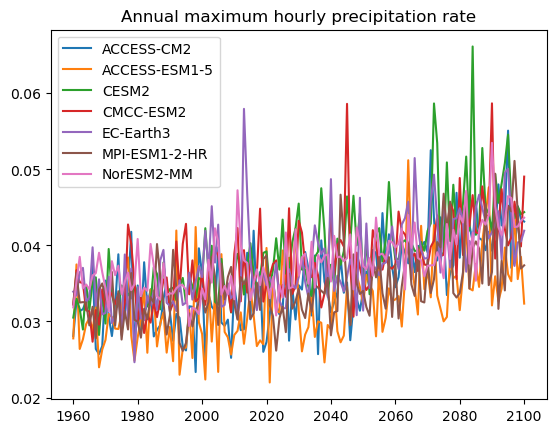

In [16]:
# !!! REMOVE FOR EXERCISE !!!
for model in model_list:
    plt.plot(prhmax_model_mn[model]["time"].dt.year, prhmax_model_mn[model], label=model)
    plt.legend()
    plt.title("Annual maximum hourly precipitation rate")